In [1]:
!pip install nltk optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import warnings
import lightgbm as lgb
import optuna
import nltk
import matplotlib.pyplot as plt
import torch
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

from transformers import AutoModel, AutoTokenizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Построение модели на основе TF-IDF
## 1.1. Лемматизация и векторизация текстов

In [ ]:
lemmatizer = WordNetLemmatizer()

df10q = pd.read_csv('MDA_dataset_10K.csv', index_col=0)
df10q.dropna(inplace=True)

texts = df10q['MDA'].apply(lambda x: x.split()).tolist()
labels = df10q['target_10_index'].tolist()

filtered_texts = []
filtered_labels = []
for text, label in zip(texts, labels):
    if len(text) > 0:
        filtered_texts.append(text)
        filtered_labels.append(label)

texts = filtered_texts
labels = filtered_labels

lemmatized_texts = []
for text in texts:
    lemmatized_text = []
    for word in text:
        lemmatized_word = lemmatizer.lemmatize(word.lower())
    lemmatized_texts.append(lemmatized_text)

lemmatized_texts_list = [' '.join(text) for text in lemmatized_texts]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(lemmatized_texts_list)

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels, test_size=0.2, random_state=42)

## 1.2. Поиск оптимальных гиперпараметров PCA и LightGBM (Optuna)

In [ ]:
def objective(trial):

    pca_n_components = trial.suggest_uniform('pca_n_components', 0.5, 0.95)

    pca = PCA(n_components=pca_n_components)
    X_train_pca = pca.fit_transform(X_train.toarray())
    X_test_pca = pca.transform(X_test.toarray())

    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)
    }

    lgb_train = lgb.Dataset(X_train_pca, label=y_train)

    gbm = lgb.train(param, lgb_train, num_boost_round=1000)

    y_probs = gbm.predict(X_test_pca, num_iteration=gbm.best_iteration)

    auc = roc_auc_score(y_test, y_probs)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:', study.best_trial)
print('Best AUC:', study.best_value)
print('Best hyperparameters:', study.best_params)

[I 2025-03-13 16:02:11,248] A new study created in memory with name: no-name-4362204f-a941-4823-a027-78ff21b2628c
[I 2025-03-13 16:02:57,635] Trial 0 finished with value: 0.5426952336593697 and parameters: {'pca_n_components': 0.8467443296260382, 'num_leaves': 92, 'learning_rate': 0.02918427090415836, 'max_depth': 9, 'min_child_samples': 80, 'lambda_l1': 2.780777438248642, 'lambda_l2': 0.010289610706535663}. Best is trial 0 with value: 0.5426952336593697.
[I 2025-03-13 16:03:20,490] Trial 1 finished with value: 0.5996739636702375 and parameters: {'pca_n_components': 0.6124688126692582, 'num_leaves': 129, 'learning_rate': 0.003278411696142187, 'max_depth': 6, 'min_child_samples': 79, 'lambda_l1': 0.5966741216347178, 'lambda_l2': 0.00018724118527504966}. Best is trial 1 with value: 0.5996739636702375.
[I 2025-03-13 16:03:45,072] Trial 2 finished with value: 0.5636547120012421 and parameters: {'pca_n_components': 0.8597869984007521, 'num_leaves': 60, 'learning_rate': 0.1832197259066776, '

Best trial: FrozenTrial(number=21, state=1, values=[0.6402344356466387], datetime_start=datetime.datetime(2025, 3, 13, 16, 11, 32, 83346), datetime_complete=datetime.datetime(2025, 3, 13, 16, 11, 53, 582598), params={'pca_n_components': 0.5606855688634134, 'num_leaves': 95, 'learning_rate': 0.00152034285182398, 'max_depth': 5, 'min_child_samples': 60, 'lambda_l1': 1.0934156036200342e-08, 'lambda_l2': 1.1445516337375753e-07}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pca_n_components': FloatDistribution(high=0.95, log=False, low=0.5, step=None), 'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.001, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=1, step=1), 'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-

Наиболее ресурсозатратная операция в обучении - подбор гиперпараметров PCA. По итогам оптимизации установлено, что оптимальное значение доли дисперсии PCA лежит в диапазоне 0.55-0.68.   
Наилучшее качество модели на TF-IDF по ROC-AUC составило 0.64, что в целом не является существенным приростом к предыдущей модели (0.62). Попробуем изменить подход к векторизации и использовать трансформеры.

# 2. Построение модели с использованием трансформеров (FinBERT)

In [ ]:
device = torch.device("cuda")

df10q = pd.read_csv('MDA_dataset_10K.csv', index_col=0)
df10q.dropna(inplace=True)

texts = df10q['MDA'].tolist()
labels = df10q['target_10_index'].tolist()

start_text = 1500 # best 1500

processed_texts = []
processed_labels = []
for text, label in zip(texts, labels):
    if len(text) > 0:
        if len(text) >= start_text:
            processed_text = text[start_text:]
        else:
            processed_text = text
        processed_texts.append(processed_text)
        processed_labels.append(label)

texts = processed_texts
labesls = processed_labels

tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModel.from_pretrained('ProsusAI/finbert')

model.to(device)

def get_text_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        max_length=512,
        padding='max_length',
        truncation=True
    ).to(device)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.detach().cpu().numpy()[0]

vectors = [get_text_embedding(text) for text in texts]

X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.2, random_state=42)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
pca = PCA(n_components=0.865) # best 0.865 auc 0.685 #100 итераций
X_train_pca = pca.fit_transform(np.array(X_train))
X_test_pca = pca.transform(np.array(X_test))

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)
    }

    lgb_train = lgb.Dataset(X_train_pca, label=y_train)

    gbm = lgb.train(param, lgb_train, num_boost_round=1000)

    y_probs = gbm.predict(X_test_pca, num_iteration=gbm.best_iteration)

    auc = roc_auc_score(y_test, y_probs)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print('Best trial:', study.best_trial)
print('Best AUC:', study.best_value)
print('Best hyperparameters:', study.best_params)

[I 2025-05-12 15:34:44,398] A new study created in memory with name: no-name-b5fb7dc0-30d2-42eb-b2a5-bd73de5ea306
[I 2025-05-12 15:34:45,615] Trial 0 finished with value: 0.5704859493867412 and parameters: {'num_leaves': 50, 'learning_rate': 0.02725649008947524, 'max_depth': 3, 'min_child_samples': 1, 'lambda_l1': 7.982708872406965e-06, 'lambda_l2': 9.364355382829153e-08}. Best is trial 0 with value: 0.5704859493867412.
[I 2025-05-12 15:34:46,788] Trial 1 finished with value: 0.605263157894737 and parameters: {'num_leaves': 136, 'learning_rate': 0.07013085160857922, 'max_depth': 19, 'min_child_samples': 44, 'lambda_l1': 0.01728205012598105, 'lambda_l2': 3.844977323384548e-07}. Best is trial 1 with value: 0.605263157894737.
[I 2025-05-12 15:34:47,456] Trial 2 finished with value: 0.572349014128241 and parameters: {'num_leaves': 99, 'learning_rate': 1.2628739346991892e-06, 'max_depth': 5, 'min_child_samples': 54, 'lambda_l1': 1.3253001112278135e-08, 'lambda_l2': 4.731478497026188}. Best 

Best trial: FrozenTrial(number=361, state=1, values=[0.6853749417792268], datetime_start=datetime.datetime(2025, 5, 12, 15, 41, 5, 395727), datetime_complete=datetime.datetime(2025, 5, 12, 15, 41, 7, 475174), params={'num_leaves': 107, 'learning_rate': 0.005484191770733688, 'max_depth': 11, 'min_child_samples': 64, 'lambda_l1': 0.00018360873132500807, 'lambda_l2': 1.0886816488446517e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=1e-06, step=None), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=1, step=1), 'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None)}, trial_id=361, value=None)
Best AUC: 0.6853749417792268
Best hyperparameters: {'num_leaves': 107, 'lea

Модель на трансформерах показала наилучшие результаты. ROC-AUC вырос до 0.69, что является существенным приростом к предыдущему чекпоинту (0.62)

In [ ]:
def objective(trial):
    n_components = trial.suggest_float('pca_n_components', 0.79, 0.91)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(np.array(X_train))
    X_test_pca = pca.transform(np.array(X_test))

    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)
    }

    lgb_train = lgb.Dataset(X_train_pca, label=y_train)

    gbm = lgb.train(param, lgb_train, num_boost_round=1000)

    y_probs = gbm.predict(X_test_pca, num_iteration=gbm.best_iteration)

    auc = roc_auc_score(y_test, y_probs)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=800)

print('Best trial:', study.best_trial)
print('Best AUC:', study.best_value)
print('Best hyperparameters:', study.best_params)

[I 2025-05-12 15:43:38,839] A new study created in memory with name: no-name-84dcbdf0-90c1-4b8d-9fdc-757417168b09
[I 2025-05-12 15:43:39,671] Trial 0 finished with value: 0.6282021425244527 and parameters: {'pca_n_components': 0.8252808971176153, 'num_leaves': 124, 'learning_rate': 0.001991538964593214, 'max_depth': 12, 'min_child_samples': 72, 'lambda_l1': 3.077355216617365e-07, 'lambda_l2': 8.294311222003665e-08}. Best is trial 0 with value: 0.6282021425244527.
[I 2025-05-12 15:43:40,593] Trial 1 finished with value: 0.6017699115044248 and parameters: {'pca_n_components': 0.8568690070663013, 'num_leaves': 108, 'learning_rate': 0.011213035300191937, 'max_depth': 4, 'min_child_samples': 25, 'lambda_l1': 4.944320730497687e-08, 'lambda_l2': 0.0002960593190094902}. Best is trial 0 with value: 0.6282021425244527.
[I 2025-05-12 15:43:41,785] Trial 2 finished with value: 0.591212544635926 and parameters: {'pca_n_components': 0.894590710551197, 'num_leaves': 50, 'learning_rate': 0.01601844169

Best trial: FrozenTrial(number=507, state=1, values=[0.6830461108523521], datetime_start=datetime.datetime(2025, 5, 12, 15, 53, 11, 556914), datetime_complete=datetime.datetime(2025, 5, 12, 15, 53, 12, 499140), params={'pca_n_components': 0.8841934396374089, 'num_leaves': 74, 'learning_rate': 0.006722699154219179, 'max_depth': 5, 'min_child_samples': 98, 'lambda_l1': 4.888503000500968e-08, 'lambda_l2': 7.976880813504016e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pca_n_components': FloatDistribution(high=0.91, log=False, low=0.79, step=None), 'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=1e-06, step=None), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=1, step=1), 'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1

# 3. Обучение модели с лучшими гиперпараметрами.

In [ ]:
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'auc'
best_params['boosting_type'] = 'gbdt'
best_params['verbosity'] = -1

lgb_train = lgb.Dataset(X_train_pca, label=y_train)
best_gbm = lgb.train(best_params, lgb_train, num_boost_round=1000)

y_probs_best = best_gbm.predict(X_test_pca, num_iteration=best_gbm.best_iteration)

auc_best = roc_auc_score(y_test, y_probs_best)
print('AUC лучшей модели на тестовом наборе:', auc_best)

AUC лучшей модели на тестовом наборе: 0.6905759975159137


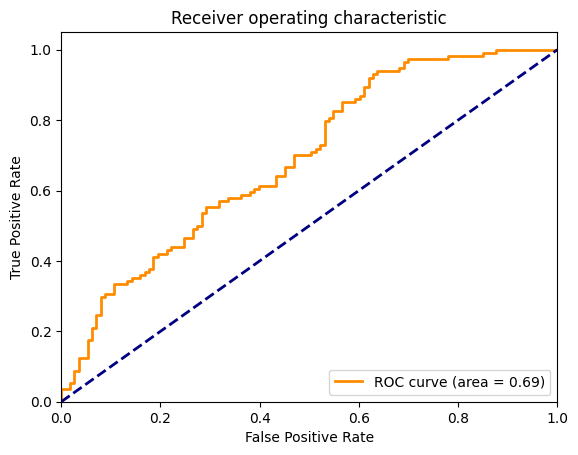

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs_best)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# with open('best_model_and_pca.pkl', 'wb') as file:
#     pickle.dump((best_gbm, pca), file)

# with open('best_model_and_pca.pkl', 'rb') as file:
#     loaded_gbm, loaded_pca = pickle.load(file)

# 4. Построение классификатора на основе нейронной сети

### 4.1. Формируем датасет эмбеддингов

In [ ]:
device = torch.device("cuda")

df10q = pd.read_csv('MDA_dataset_10K.csv', index_col=0)
df10q.dropna(inplace=True)

texts = df10q['MDA'].tolist()
labels = df10q['target_10_index'].tolist()

start_text = 1500 # best 1500

processed_texts = []
processed_labels = []
for text, label in zip(texts, labels):
    if len(text) > 0:
        if len(text) >= start_text:
            processed_text = text[start_text:]
        else:
            processed_text = text
        processed_texts.append(processed_text)
        processed_labels.append(label)

texts = processed_texts
labesls = processed_labels

tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModel.from_pretrained('ProsusAI/finbert')

model.to(device)

def get_text_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        max_length=512,
        padding='max_length',
        truncation=True
    ).to(device)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.detach().cpu().numpy()[0]

vectors = [get_text_embedding(text) for text in texts]

X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.2, random_state=42)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

### 4.2. Снижаем размерность с помощью PCA

In [ ]:
pca = PCA(n_components=0.865)
X_train_pca = pca.fit_transform(np.array(X_train))
X_test_pca = pca.transform(np.array(X_test))

### 4.3. Задаем архитектуру нейронной сети

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.utils import class_weight
import optuna

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Преобразуем numpy-массивы в тензоры и перемещаем их на GPU
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Создаем датасеты и загрузчики
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Определяем модель
class ImprovedClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim1=256, hidden_dim2=128):
        super(ImprovedClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

def objective(trial):
    # Оптимизация гиперпараметров
    hidden_dim1 = trial.suggest_int('hidden_dim1', 128, 512)
    hidden_dim2 = trial.suggest_int('hidden_dim2', 64, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    model = ImprovedClassifier(input_dim=X_train_pca.shape[1], num_classes=len(np.unique(y_train)),
                               hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2).to(device)

    criterion = nn.CrossEntropyLoss()

    # Вычисляем веса классов для балансировки потерь
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 100

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

    # Оценка на тесте
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Вычисляем ROC AUC для многоклассовой классификации (один против всех)
    roc_auc_scores = {}

    for i in range(len(np.unique(y_train))):
        roc_auc_scores[i] = roc_auc_score(all_labels == i, all_probs[:, i])

    mean_roc_auc_score = np.mean(list(roc_auc_scores.values()))

    return mean_roc_auc_score

# Запуск оптимизации с помощью Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Количество испытаний можно изменить

print("Best hyperparameters: ", study.best_params)
print("Best ROC AUC: ", study.best_value)

[I 2025-05-09 11:28:27,546] A new study created in memory with name: no-name-0110c717-66ff-42d3-ad32-0b480502bd14
[I 2025-05-09 11:28:33,056] Trial 0 finished with value: 0.5485949386741189 and parameters: {'hidden_dim1': 308, 'hidden_dim2': 91, 'learning_rate': 1.6984531242136756e-05}. Best is trial 0 with value: 0.5485949386741189.
[I 2025-05-09 11:28:36,159] Trial 1 finished with value: 0.5936966309579258 and parameters: {'hidden_dim1': 239, 'hidden_dim2': 228, 'learning_rate': 0.0002072863243893614}. Best is trial 1 with value: 0.5936966309579258.
[I 2025-05-09 11:28:39,321] Trial 2 finished with value: 0.5581431454743052 and parameters: {'hidden_dim1': 372, 'hidden_dim2': 195, 'learning_rate': 1.5253810854618168e-05}. Best is trial 1 with value: 0.5936966309579258.
[I 2025-05-09 11:28:42,451] Trial 3 finished with value: 0.5914454277286135 and parameters: {'hidden_dim1': 263, 'hidden_dim2': 208, 'learning_rate': 0.0008755593121406021}. Best is trial 1 with value: 0.593696630957925

Best hyperparameters:  {'hidden_dim1': 244, 'hidden_dim2': 236, 'learning_rate': 8.281619226230952e-05}
Best ROC AUC:  0.6156652693681106


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.utils import class_weight
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class ImprovedClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim1=256, hidden_dim2=128):
        super(ImprovedClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

def objective(trial):
    hidden_dim1 = trial.suggest_int('hidden_dim1', 128, 512)
    hidden_dim2 = trial.suggest_int('hidden_dim2', 64, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    model = ImprovedClassifier(input_dim=X_train_pca.shape[1], num_classes=len(np.unique(y_train)),
                               hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2).to(device)

    criterion = nn.CrossEntropyLoss()

    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)  # Используем AdamW

    num_epochs = trial.suggest_int('num_epochs', 10, 50) # Оптимизация количества эпох

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

    # Оценка на тесте
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    roc_auc_scores = {}

    for i in range(len(np.unique(y_train))):
        roc_auc_scores[i] = roc_auc_score(all_labels == i, all_probs[:, i])

    mean_roc_auc_score = np.mean(list(roc_auc_scores.values()))

    return mean_roc_auc_score

# Запуск оптимизации с помощью Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters: ", study.best_params)
print("Best ROC AUC: ", study.best_value)

[I 2025-05-09 11:34:19,124] A new study created in memory with name: no-name-99d67058-df0d-4692-a9d6-d0f01987c3c9
[I 2025-05-09 11:34:21,681] Trial 0 finished with value: 0.5618692749573048 and parameters: {'hidden_dim1': 171, 'hidden_dim2': 244, 'learning_rate': 4.7390081574834024e-05, 'num_epochs': 27}. Best is trial 0 with value: 0.5618692749573048.
[I 2025-05-09 11:34:23,952] Trial 1 finished with value: 0.5586865393572428 and parameters: {'hidden_dim1': 336, 'hidden_dim2': 184, 'learning_rate': 0.026359800391832652, 'num_epochs': 23}. Best is trial 0 with value: 0.5618692749573048.
[I 2025-05-09 11:34:28,077] Trial 2 finished with value: 0.5309734513274336 and parameters: {'hidden_dim1': 394, 'hidden_dim2': 219, 'learning_rate': 0.020852832120436583, 'num_epochs': 33}. Best is trial 0 with value: 0.5618692749573048.
[I 2025-05-09 11:34:31,920] Trial 3 finished with value: 0.5829063809967396 and parameters: {'hidden_dim1': 437, 'hidden_dim2': 242, 'learning_rate': 1.310558503068250

Best hyperparameters:  {'hidden_dim1': 318, 'hidden_dim2': 76, 'learning_rate': 0.09746825944846592, 'num_epochs': 13}
Best ROC AUC:  0.6289201987269057


# 5. Стекинг

In [ ]:
device = torch.device("cuda")

df10q = pd.read_csv('MDA_dataset_10K.csv', index_col=0)
df10q.dropna(inplace=True)

texts = df10q['MDA'].tolist()
labels = df10q['target_10_index'].tolist()

start_text = 1500 # best 1500

processed_texts = []
processed_labels = []
for text, label in zip(texts, labels):
    if len(text) > 0:
        if len(text) >= start_text:
            processed_text = text[start_text:]
        else:
            processed_text = text
        processed_texts.append(processed_text)
        processed_labels.append(label)

texts = processed_texts
labesls = processed_labels

tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModel.from_pretrained('ProsusAI/finbert')

model.to(device)

def get_text_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        max_length=512,
        padding='max_length',
        truncation=True
    ).to(device)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.detach().cpu().numpy()[0]

vectors = [get_text_embedding(text) for text in texts]

X = np.array(vectors)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
pca = PCA(n_components=0.865) # best 0.865 auc 0.685 #100 итераций
X_train_pca = pca.fit_transform(np.array(X_train))
X_test_pca = pca.transform(np.array(X_test))

In [7]:
def get_meta_features(models, X, y, n_splits=5):
    meta_features = np.zeros((X.shape[0], len(models)))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for idx, model in enumerate(models):
        meta_feature = np.zeros(X.shape[0])
        for train_idx, val_idx in kf.split(X):
            X_train_fold = X[train_idx]
            X_val_fold = X[val_idx]
            y_train_fold = y[train_idx]
            model_clone = clone(model)
            model_clone.fit(X_train_fold, y_train_fold)
            meta_feature[val_idx] = model_clone.predict_proba(X_val_fold)[:,1]
        meta_features[:, idx] = meta_feature
    return meta_features

def objective(trial):

    lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }

    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 50, 300),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
    }

    model_lgb = lgb.LGBMClassifier(**lgb_params)
    model_rf = RandomForestClassifier(**rf_params)

    models = [model_lgb, model_rf]

    meta_train = get_meta_features(models, X_train_pca, y_train)

    meta_model = LogisticRegression()
    meta_model.fit(meta_train, y_train)

    for model in models:
        model.fit(X_train_pca, y_train)

    meta_test = np.zeros((X_test_pca.shape[0], len(models)))
    for idx, model in enumerate(models):
        meta_test[:, idx] = model.predict_proba(X_test_pca)[:,1]

    final_preds = meta_model.predict_proba(meta_test)[:,1]

    auc_score = roc_auc_score(y_test, final_preds)

    return auc_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1600)

print("Лучшие гиперпараметры:", study.best_params)
print("Лучшее значение AUC:", study.best_value)

[I 2025-06-07 06:27:36,337] A new study created in memory with name: no-name-406a2b3f-b8a5-4247-ba19-024ce4556bf8
[I 2025-06-07 06:27:40,774] Trial 0 finished with value: 0.6210992081974849 and parameters: {'num_leaves': 32, 'learning_rate': 0.17786067835453323, 'max_depth': 18, 'min_child_samples': 40, 'lambda_l1': 1.0622070319827018e-08, 'lambda_l2': 0.00012927369927434262, 'rf_n_estimators': 133, 'rf_max_depth': 6, 'rf_min_samples_split': 3}. Best is trial 0 with value: 0.6210992081974849.
[I 2025-06-07 06:27:43,236] Trial 1 finished with value: 0.6009548206800186 and parameters: {'num_leaves': 108, 'learning_rate': 0.01245350852369973, 'max_depth': 10, 'min_child_samples': 26, 'lambda_l1': 0.4058864652891086, 'lambda_l2': 0.04067021239056576, 'rf_n_estimators': 101, 'rf_max_depth': 3, 'rf_min_samples_split': 16}. Best is trial 0 with value: 0.6210992081974849.
[I 2025-06-07 06:27:52,018] Trial 2 finished with value: 0.5865548827821766 and parameters: {'num_leaves': 130, 'learning_r

Лучшие гиперпараметры: {'num_leaves': 148, 'learning_rate': 0.05668274998264739, 'max_depth': 14, 'min_child_samples': 67, 'lambda_l1': 9.149821189298525e-08, 'lambda_l2': 0.004572641661348083, 'rf_n_estimators': 292, 'rf_max_depth': 3, 'rf_min_samples_split': 9}
Лучшее значение AUC: 0.6960875640428504


# 6. Обучение модели с лучшими гиперпараметрами

In [ ]:
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'num_leaves': 148,
    'learning_rate': 0.05668274998264739,
    'max_depth': 14,
    'min_child_samples': 67,
    'lambda_l1': 9.149821189298525e-08,
    'lambda_l2': 0.004572641661348083,
    'random_state': 42
}

rf_params = {
    'n_estimators': 292,
    'max_depth': 3,
    'min_samples_split': 9,
    'random_state': 42,
    'n_jobs': -1
}

model_lgb = lgb.LGBMClassifier(**lgb_params)
model_rf = RandomForestClassifier(**rf_params)

models = [model_lgb, model_rf]

meta_train = get_meta_features(models, X_train_pca, y_train)

meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(meta_train, y_train)

for model in models:
    model.fit(X_train_pca, y_train)

In [ ]:
with open('model_lgb.pkl', 'wb') as f:
    pickle.dump(model_lgb, f)

with open('model_rf.pkl', 'wb') as f:
    pickle.dump(model_rf, f)

with open('meta_model.pkl', 'wb') as f:
    pickle.dump(meta_model, f)